In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#cd '/content/drive/My Drive/Fall 2020/NYU_Team18_Accern_Capstone_Fall2020/'

/content/drive/.shortcut-targets-by-id/14ZkfgKUfI9-nZAJWWGVmgLO13Hh-rZJL/NYU_Team18_Accern_Capstone_Fall2020


In [2]:
cd '/content/drive/My Drive/Fall 2020/1006 Capstone/NYU_Team18_Accern_Capstone_Fall2020/'

/content/drive/My Drive/Fall 2020/1006 Capstone/NYU_Team18_Accern_Capstone_Fall2020


In [3]:
!pip install transformers
!pip install pytorch-lightning==1.0.8

     |████████████████████████████████| 1.4MB 14.0MB/s 
     |████████████████████████████████| 2.9MB 49.2MB/s 
     |████████████████████████████████| 890kB 50.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=b6dcaf644ad27af6ff4d561eb6732df6912ece0849feba55129bc3cf59247739
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 563kB 13.3MB/s 
     |████████████████████████████████| 276kB 31.3MB/s 
     |████████████████████████████████| 92kB 11.1MB/s 
     |████████████████████████████████| 829kB 31.9MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44620 sha256=5ef8ca7f36420b8db3ccae017b56848548784a54d654e0c5faf74e844caff3e8
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future

In [4]:
import numpy as np
import pandas as pd
import torch

from read_data import *
from FinSentiment import *

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


### Train on Correct

In [ ]:
pretrained_bert_name = 'distilbert-base-cased'
incorrect_type = 'correct'
company_embedding_method = 'sum_embedding'
company_weight = 1
burn_in_epochs = 2
max_epochs = burn_in_epochs + 4
existing_company_only = False

model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method, f'cpy_wt{company_weight}']) + '_full_data'

#############################################################################################
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_bert_name)
(train_ids,X_train,y_train), (val_ids,X_val,y_val), (test_ids,X_test,y_test), _ = read_data(incorrect_type, dir_path='data/', existing_company_only=existing_company_only, sample=None)

X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])
train_ids = np.concatenate([train_ids, val_ids])

train_dataloader = tokenize_and_dataloader(X_train, y_train, tokenizer, train_ids, 16, 4, random=True)
val_dataloader = tokenize_and_dataloader(X_test, y_test, tokenizer, test_ids, 16, 4, random=False)

#############################################################################################
model = FinSentiment(pretrained_bert_name, incorrect_type, company_embedding_method, company_weight, 
                     lr=5e-5, hidden_dropout_prob=0.1, discriminate=True, burn_in_epochs=burn_in_epochs)

logger = TensorBoardLogger('experiments/logs', name=model_name)
checkpoint_callback = ModelCheckpoint(
    filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name,
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
    verbose=False
)
trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1, max_epochs=max_epochs, logger=logger, callbacks=[checkpoint_callback], fast_dev_run=False)
trainer.fit(model, train_dataloader, val_dataloader)

trainer.save_checkpoint('experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name + '_last.ckpt')


[PROGRESS] Saving hyperparameters
[PROGRESS] Initializing BERT model



[PROGRESS] Initializing Company Embedding Layer
[PROGRESS] Initializing classifier
[PROGRESS] Done initialization


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type            | Params
--------------------------------------------------
0 | bert          | DistilBertModel | 65.2 M
1 | company_layer | Embedding       | 808 K 
2 | classifier    | Sequential      | 594 K 
3 | pooler        | BertPooler      | 590 K 
4 | dropout       | Dropout         | 0     


[PROGRESS] Burning in classifier epoch 0


[PROGRESS] Burning in classifier epoch 1


Saving latest checkpoint...


[MODEL NAME]: distilbert-base-cased_correct_sum_embedding 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9334
	Weighted Accuracy: 	0.9545
	F1 Score: 		0.9334
	AUC_SCORE[CLS 0]: 	0.9990
	AUC_SCORE[CLS 1]: 	0.9879
	AUC_SCORE[CLS 2]: 	0.9615
	AUC_SCORE[CLS 3]: 	0.9795
	AUC_SCORE[CLS 4]: 	0.9977

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (12) and target (5) number of classes
  warnings.warn(*args, **kwargs)


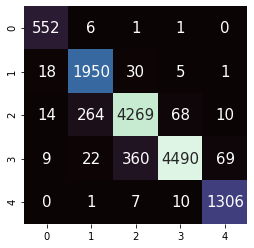

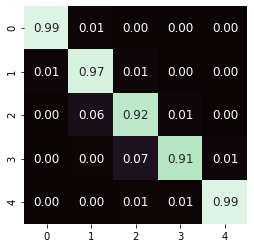

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_correct_sum_embedding 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8332
	Weighted Accuracy: 	0.8034
	F1 Score: 		0.8332
	AUC_SCORE[CLS 0]: 	0.7789
	AUC_SCORE[CLS 1]: 	0.7561
	AUC_SCORE[CLS 2]: 	0.9572
	AUC_SCORE[CLS 3]: 	0.8906
	AUC_SCORE[CLS 4]: 	0.9216

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (12) and target (5) number of classes
  warnings.warn(*args, **kwargs)


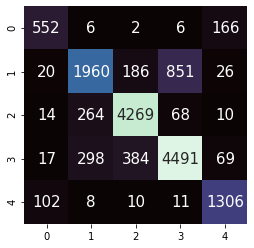

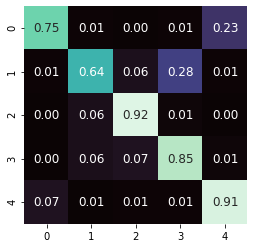

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_correct_sum_embedding 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.8528
	Drop Total Sample: 		1188.0000
--------------------------------------------------------------------------------



In [ ]:
evaluate_model(model, tokenizer, trainer, existing_company_only=False, dir_path='data/',batch_size=16, num_workers=4)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (12) and target (5) number of classes
  warnings.warn(*args, **kwargs)


[MODEL NAME]: distilbert-base-cased_correct_sum_embedding 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9309
	Weighted Accuracy: 	0.9524
	F1 Score: 		0.9309
	AUC_SCORE[CLS 0]: 	0.9984
	AUC_SCORE[CLS 1]: 	0.9874
	AUC_SCORE[CLS 2]: 	0.9584
	AUC_SCORE[CLS 3]: 	0.9803
	AUC_SCORE[CLS 4]: 	0.9982

Confusion Matrix


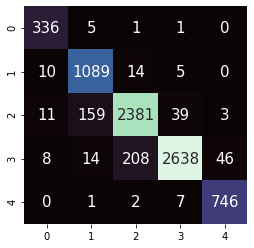

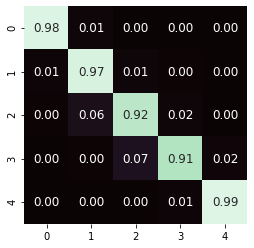

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_correct_sum_embedding 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8238
	Weighted Accuracy: 	0.7916
	F1 Score: 		0.8238
	AUC_SCORE[CLS 0]: 	0.7794
	AUC_SCORE[CLS 1]: 	0.7349
	AUC_SCORE[CLS 2]: 	0.9537
	AUC_SCORE[CLS 3]: 	0.8864
	AUC_SCORE[CLS 4]: 	0.9128

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (12) and target (5) number of classes
  warnings.warn(*args, **kwargs)


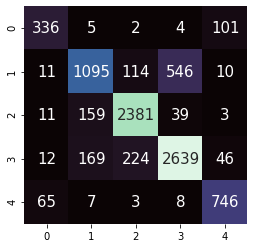

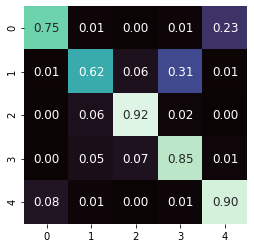

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_correct_sum_embedding 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.8419
	Drop Total Sample: 		710.0000
--------------------------------------------------------------------------------



In [ ]:
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)

### Train on Inverse

In [5]:
pretrained_bert_name = 'distilbert-base-cased'
incorrect_type = 'inverse'
company_embedding_method = 'sum_embedding'
company_weight = 1
burn_in_epochs = 2
max_epochs = burn_in_epochs + 4
existing_company_only = False

model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method, f'cpy_wt{company_weight}']) +'_full_data'

#############################################################################################
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_bert_name)
(train_ids,X_train,y_train), (val_ids,X_val,y_val), (test_ids,X_test,y_test), _ = read_data(incorrect_type, dir_path='data/', existing_company_only=existing_company_only, sample=None)

X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])
train_ids = np.concatenate([train_ids, val_ids])

train_dataloader = tokenize_and_dataloader(X_train, y_train, tokenizer, train_ids, 16, 4, random=True)
val_dataloader = tokenize_and_dataloader(X_test, y_test, tokenizer, test_ids, 16, 4, random=False)

#############################################################################################
model = FinSentiment(pretrained_bert_name, incorrect_type, company_embedding_method, company_weight, 
                     lr=5e-5, hidden_dropout_prob=0.1, discriminate=True, burn_in_epochs=burn_in_epochs)

logger = TensorBoardLogger('experiments/logs', name=model_name)
checkpoint_callback = ModelCheckpoint(
    filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name,
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
    verbose=False
)
trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1, max_epochs=max_epochs, logger=logger, callbacks=[checkpoint_callback], fast_dev_run=False)
trainer.fit(model, train_dataloader, val_dataloader)

trainer.save_checkpoint('experiments/saved_models/' +  company_embedding_method + '/' + model_name + '/' + model_name + '_last.ckpt')


[PROGRESS] Saving hyperparameters
[PROGRESS] Initializing BERT model


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[PROGRESS] Initializing Company Embedding Layer
[PROGRESS] Initializing classifier
[PROGRESS] Done initialization



  | Name          | Type            | Params
--------------------------------------------------
0 | bert          | DistilBertModel | 65.2 M
1 | company_layer | Embedding       | 808 K 
2 | classifier    | Sequential      | 594 K 
3 | pooler        | BertPooler      | 590 K 
4 | dropout       | Dropout         | 0     


[PROGRESS] Burning in classifier epoch 0


[PROGRESS] Burning in classifier epoch 1


Saving latest checkpoint...


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (8) and target (5) number of classes
  warnings.warn(*args, **kwargs)


[MODEL NAME]: distilbert-base-cased_inverse_sum_embedding 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9338
	Weighted Accuracy: 	0.9468
	F1 Score: 		0.9338
	AUC_SCORE[CLS 0]: 	0.9966
	AUC_SCORE[CLS 1]: 	0.9536
	AUC_SCORE[CLS 2]: 	0.9804
	AUC_SCORE[CLS 3]: 	0.9565
	AUC_SCORE[CLS 4]: 	0.9974

Confusion Matrix


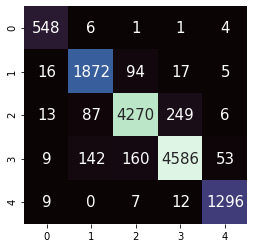

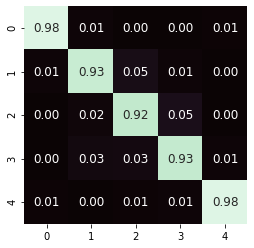

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_inverse_sum_embedding 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.9007
	Weighted Accuracy: 	0.9106
	F1 Score: 		0.9007
	AUC_SCORE[CLS 0]: 	0.9953
	AUC_SCORE[CLS 1]: 	0.9340
	AUC_SCORE[CLS 2]: 	0.9812
	AUC_SCORE[CLS 3]: 	0.9322
	AUC_SCORE[CLS 4]: 	0.9956

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (8) and target (5) number of classes
  warnings.warn(*args, **kwargs)


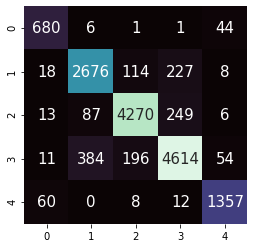

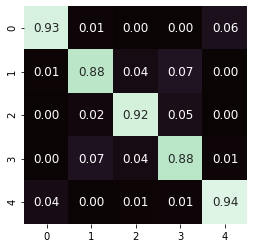

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_inverse_sum_embedding 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.9061
	Drop Total Sample: 		942.0000
--------------------------------------------------------------------------------



In [6]:
evaluate_model(model, tokenizer, trainer, existing_company_only=False, dir_path='data/',batch_size=16, num_workers=4)

[MODEL NAME]: distilbert-base-cased_inverse_sum_embedding 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9341
	Weighted Accuracy: 	0.9472
	F1 Score: 		0.9341
	AUC_SCORE[CLS 0]: 	0.9952
	AUC_SCORE[CLS 1]: 	0.9563
	AUC_SCORE[CLS 2]: 	0.9801
	AUC_SCORE[CLS 3]: 	0.9591
	AUC_SCORE[CLS 4]: 	0.9981

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (8) and target (5) number of classes
  warnings.warn(*args, **kwargs)


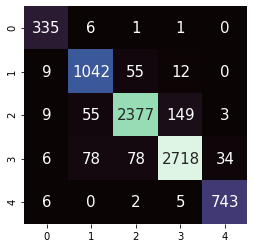

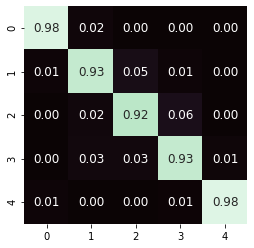

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_inverse_sum_embedding 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.9019
	Weighted Accuracy: 	0.9097
	F1 Score: 		0.9019
	AUC_SCORE[CLS 0]: 	0.9935
	AUC_SCORE[CLS 1]: 	0.9408
	AUC_SCORE[CLS 2]: 	0.9810
	AUC_SCORE[CLS 3]: 	0.9352
	AUC_SCORE[CLS 4]: 	0.9959

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (8) and target (5) number of classes
  warnings.warn(*args, **kwargs)


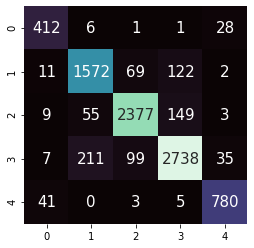

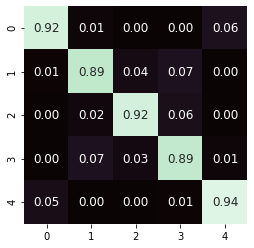

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_inverse_sum_embedding 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.9060
	Drop Total Sample: 		568.0000
--------------------------------------------------------------------------------



In [7]:
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)

### Train on Boundary

In [8]:
pretrained_bert_name = 'distilbert-base-cased'
incorrect_type = 'boundary'
company_embedding_method = 'sum_embedding'
company_weight = 1
burn_in_epochs = 2
max_epochs = burn_in_epochs + 4
existing_company_only = False

model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method, f'cpy_wt{company_weight}']) +'_full_data'

#############################################################################################
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_bert_name)
(train_ids,X_train,y_train), (val_ids,X_val,y_val), (test_ids,X_test,y_test), _ = read_data(incorrect_type, dir_path='data/', existing_company_only=existing_company_only, sample=None)

X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])
train_ids = np.concatenate([train_ids, val_ids])

train_dataloader = tokenize_and_dataloader(X_train, y_train, tokenizer, train_ids, 16, 4, random=True)
val_dataloader = tokenize_and_dataloader(X_test, y_test, tokenizer, test_ids, 16, 4, random=False)

#############################################################################################
model = FinSentiment(pretrained_bert_name, incorrect_type, company_embedding_method, company_weight, 
                     lr=5e-5, hidden_dropout_prob=0.1, discriminate=True, burn_in_epochs=burn_in_epochs)

logger = TensorBoardLogger('experiments/logs', name=model_name)
checkpoint_callback = ModelCheckpoint(
    filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name,
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
    verbose=False
)
trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1, max_epochs=max_epochs, logger=logger, callbacks=[checkpoint_callback], fast_dev_run=False)
trainer.fit(model, train_dataloader, val_dataloader)

trainer.save_checkpoint('experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name + '_last.ckpt')

[PROGRESS] Saving hyperparameters
[PROGRESS] Initializing BERT model


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[PROGRESS] Initializing Company Embedding Layer
[PROGRESS] Initializing classifier
[PROGRESS] Done initialization



  | Name          | Type            | Params
--------------------------------------------------
0 | bert          | DistilBertModel | 65.2 M
1 | company_layer | Embedding       | 808 K 
2 | classifier    | Sequential      | 594 K 
3 | pooler        | BertPooler      | 590 K 
4 | dropout       | Dropout         | 0     


[PROGRESS] Burning in classifier epoch 0


[PROGRESS] Burning in classifier epoch 1


Saving latest checkpoint...


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (8) and target (5) number of classes
  warnings.warn(*args, **kwargs)


[MODEL NAME]: distilbert-base-cased_boundary_sum_embedding 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9202
	Weighted Accuracy: 	0.9253
	F1 Score: 		0.9202
	AUC_SCORE[CLS 0]: 	0.9918
	AUC_SCORE[CLS 1]: 	0.9842
	AUC_SCORE[CLS 2]: 	0.9721
	AUC_SCORE[CLS 3]: 	0.9876
	AUC_SCORE[CLS 4]: 	0.9956

Confusion Matrix


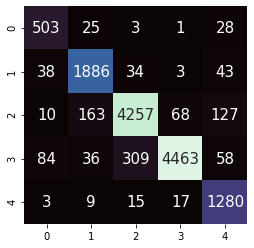

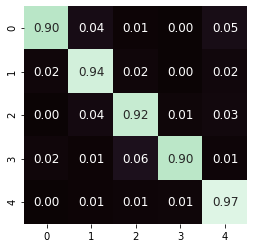

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_sum_embedding 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8314
	Weighted Accuracy: 	0.8190
	F1 Score: 		0.8314
	AUC_SCORE[CLS 0]: 	0.9618
	AUC_SCORE[CLS 1]: 	0.9668
	AUC_SCORE[CLS 2]: 	0.9752
	AUC_SCORE[CLS 3]: 	0.9809
	AUC_SCORE[CLS 4]: 	0.9856

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (8) and target (5) number of classes
  warnings.warn(*args, **kwargs)


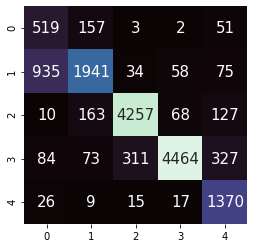

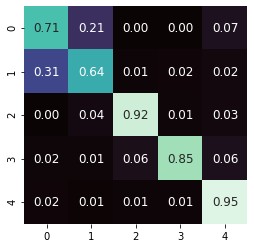

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_sum_embedding 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.9606
	Drop Total Sample: 		752.0000
--------------------------------------------------------------------------------



In [9]:
evaluate_model(model, tokenizer, trainer, existing_company_only=False, dir_path='data/',batch_size=16, num_workers=4)

[MODEL NAME]: distilbert-base-cased_boundary_sum_embedding 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9244
	Weighted Accuracy: 	0.9289
	F1 Score: 		0.9244
	AUC_SCORE[CLS 0]: 	0.9915
	AUC_SCORE[CLS 1]: 	0.9870
	AUC_SCORE[CLS 2]: 	0.9736
	AUC_SCORE[CLS 3]: 	0.9890
	AUC_SCORE[CLS 4]: 	0.9963

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (8) and target (5) number of classes
  warnings.warn(*args, **kwargs)


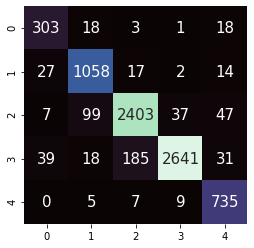

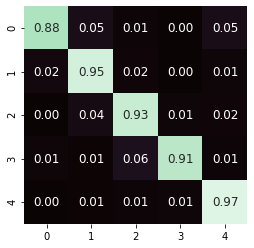

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_sum_embedding 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8281
	Weighted Accuracy: 	0.8130
	F1 Score: 		0.8281
	AUC_SCORE[CLS 0]: 	0.9568
	AUC_SCORE[CLS 1]: 	0.9646
	AUC_SCORE[CLS 2]: 	0.9768
	AUC_SCORE[CLS 3]: 	0.9809
	AUC_SCORE[CLS 4]: 	0.9839

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (8) and target (5) number of classes
  warnings.warn(*args, **kwargs)


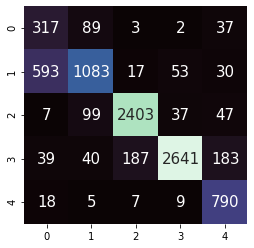

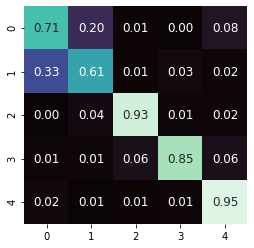

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_sum_embedding 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.9607
	Drop Total Sample: 		443.0000
--------------------------------------------------------------------------------



In [10]:
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)